Przetwarzanie zbioru plików las
--------------
**Opis projektu**

Pliki las to pliki zgodne ze standardem Log ASCII Standard, zawierające logi różnych parametrów mierzonych w otworze wiertniczym (np. średnica, porowatość, przewodnictwo elektryczne, promieniowanie gamma itp). Dane w tym projekcie pochodzą z dużego zbioru (ponad 21 000 plików) ze stanu Kansas.

Do przetwarzania plików *.las służy moduł lasio.

Każdy otwór to jeden plik, w obrębie pliku może być zapisanych wiele krzywych. Pliki są spakowane zipem, tak, że w każdym zipie jest tylko jeden plik las. Dodatkowo mamy plik tekstowy zawierający wykaz wszystkich plików z parametrami takimi jak współrzędne geograficzne, wysokość npm itp.

Wszystkie wartości w danych źródłowych są w stopach.

Celem będzie wykonanie interpolacji wybranego parametru (promieniowanie gamma) na zadanej głębokości. Ostatecznym wynikiem będzie plik geotiff z interpolowaną metodą IDW wartością gamma.

Możliwe dalsze rozwinięcie projektu, to np.


*   wygenerowanie serii interpolacji w określonym interwale głębokości
*   wygenerowanie izolinii
*   rysowanie profili wzdłuż zadanej linii
*   analiza innych zmiennych.



In [ ]:
%pip install lasio
%pip install geopandas
%pip install folium
%pip install pykrige
%pip install scikit-gstat #moduł dostępny potem jako skgstat

     |████████████████████████████████| 1.0 MB 26.3 MB/s 
     |████████████████████████████████| 6.3 MB 51.6 MB/s 
     |████████████████████████████████| 16.7 MB 337 kB/s 
     |████████████████████████████████| 734 kB 8.4 MB/s 
     |████████████████████████████████| 2.1 MB 26.0 MB/s 
  Created wheel for scikit-gstat: filename=scikit_gstat-1.0.1-py3-none-any.whl size=703496 sha256=f502a3cd8df997a6ff7d4cde21720d4958ee6e973b8d76a27200b87a98e65e01
  Stored in directory: /root/.cache/pip/wheels/0e/66/1b/692968c08959d21040075395a1e2e15ffd71823034691e1778
Successfully built scikit-gstat


In [ ]:
import pandas as pd
import numpy as np
import lasio 
import os
import glob
from zipfile import ZipFile
import matplotlib.pyplot as plt

import geopandas
import folium
import gdal

from scipy import interpolate as scinter
from skgstat import Variogram
import pykrige as pkg

%matplotlib inline

In [ ]:
#Tylko na Colabie
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Tworzenie listy plików *.zip

In [ ]:
#lista plików zip
path = "/content/drive/MyDrive/2015_sample/" #na końcu ścieżki musi być ukośnik
#path = "E:/Maciek pobrane/2020_extract/"
print(path)
filelist = []
for file in os.listdir(path):
    if file.endswith(".zip"):
        #print(file)
        filelist.append(file)
print(f"Znaleziono {len(filelist)} plików")

/content/drive/MyDrive/2015_sample/
Znaleziono 75 plików


### Odczytywanie pliku

In [ ]:
os.mkdir('las_tmp') #pliki będą wypakowywane do tymczasowego katalogu

In [ ]:
#zróbmy sobie funkcję do wczytywania plików las z zipów (przyjmuje ścieżkę do pliku zip, zwraca obiekt las)
def unzip_las_file(my_zipfile):
    with ZipFile(my_zipfile, 'r') as zipObj:
         zipObj.extractall('las_tmp')
    for filename in glob.iglob('las_tmp/*.las', recursive=False):
        las = lasio.read(filename) #odczytujemy dany plik las funkcją z modułu lasio
        #print(filename)
        os.remove(filename) #po wczytaniu do danych do obiektu las wypakowany plik nie jest już potrzebny
    return(las)

In [ ]:
#funkcja do wyciągania mnemoników wszystkich krzywych dostępnych w pliku (przyjmuje obiekt las, zwraca listę dostępnych mnemoników krzywych)
def extract_mnemonics(lasdata):
    curves_avail = lasdata.curves
    list_of_mnems = []
    for i in curves_avail:
        mnem = i.mnemonic
        list_of_mnems.append(mnem) #zapisuje wszystkie mnemoniki na liście
    #print(f"{len(list_of_mnems)} krzywych")
    return(list_of_mnems)

In [ ]:
#funkcja, która dla danego otworu las (z krzywą GR) interpoluje wartość gr na zadanej głębokości
#(bo na przykład może nie być pomiaru dla głębokości na której chcemy modelować)
#interpolacja przez np.interp

def get_GR(lasdata, depth):
  df = lasdata.df() #tworzymy ramkę z obiektu las
  dfd = df.rename_axis('Depth').reset_index() #wstawia Depth które było indeksem jako kolumnę ramki danych
  d = dfd.Depth
  g = dfd.GR
  interpolated_g = np.interp(x = depth, xp = d, fp = g)
  return(interpolated_g)




### Odczytywanie wszystkich plików

z wykorzystaniem zdefinowanej funkcji *unzip_las_file*

poszczególne obiekty las wrzucamy do listy *list_of_wells*

In [ ]:
list_of_wells = []
kgs_ids = []
for f in filelist:
    las_f = unzip_las_file(path + f)
    id = os.path.basename(f)[:-4] #uzyskanie samej nazwy pliku (bez ścieżki) i od razu odcięcie 4 ostatnich znaków (.zip)
    #print(id)
    kgs_ids.append(id)
    list_of_wells.append(las_f) #list_of_wells będzie się składała z obiektów typu las

In [ ]:
print(kgs_ids)

['1044966370', '1044966304', '1044966286', '1044966297', '1044966363', '1044966374', '1044966341', '1044966324', '1044966352', '1044966331', '1044966339', '1044966347', '1044966372', '1044966321', '1044966325', '1044966383', '1044966469', '1044966402', '1044966394', '1044966465', '1044966390', '1044966500', '1044966468', '1044966501', '1044966477', '1044966543', '1044966417', '1044966432', '1044966407', '1044966506', '1044966406', '1044966474', '1044966424', '1044966436', '1044966528', '1044966375', '1044966403', '1044966507', '1044966460', '1044966443', '1044966455', '1044966399', '1044966398', '1044966414', '1044966488', '1044966412', '1044966505', '1044966467', '1044966627', '1044966544', '1044966681', '1044966566', '1044966734', '1044966663', '1044966705', '1044966599', '1044966712', '1044966585', '1044966610', '1044966634', '1044966723', '1044966704', '1044966628', '1044966617', '1044966549', '1044966711', '1044966623', '1044966645', '1044966657', '1044966698', '1044966578', '1044

In [ ]:
os.rmdir('las_tmp')

### Wybór otworów z krzywą GR


z wykorzystaniem funkcji extract_mnemonics

obiekty las otworów z krzywą zapisywane są na liście wells_wth_gr. Równocześnie, dla każdego wybranego otworu brany jest identyfikator o właściwym indeksie z listy kgs_ids i zapisywany na listę kgs_wth_gr

In [ ]:
wells_wth_gr = []
kgs_wth_gr = []
i = 0 #licznik do wybierania odpowiadających obiektów z innej listy
for well in list_of_wells:
    well_mnems = extract_mnemonics(well)
    if ('GR' in well_mnems):
        wells_wth_gr.append(well)
        kgs_wth_gr.append(kgs_ids[i])
        #print(i)
    i = i + 1 #zwiększa licznik, ważne, że poza if!
print (f"{len(wells_wth_gr)} otworów z krzywą GR z {len(list_of_wells)} wszystkich")
print (f"{len(kgs_wth_gr)} identyfikatorów")

54 otworów z krzywą GR z 75 wszystkich
54 identyfikatorów


In [ ]:
print(kgs_wth_gr)

['1044966370', '1044966286', '1044966341', '1044966331', '1044966339', '1044966372', '1044966325', '1044966469', '1044966402', '1044966394', '1044966465', '1044966500', '1044966468', '1044966501', '1044966477', '1044966417', '1044966432', '1044966407', '1044966506', '1044966406', '1044966474', '1044966424', '1044966436', '1044966528', '1044966375', '1044966403', '1044966460', '1044966443', '1044966399', '1044966398', '1044966488', '1044966412', '1044966505', '1044966467', '1044966627', '1044966544', '1044966681', '1044966663', '1044966705', '1044966599', '1044966712', '1044966585', '1044966634', '1044966704', '1044966628', '1044966617', '1044966549', '1044966711', '1044966623', '1044966645', '1044966698', '1044966662', '1044966697', '1044966589']


### Wyciąganie danych o otworach

Pobieramy dane o otworach korzystając jednocześnie z list *wells_wth_gr* (obiekty las) i pasującej do niej *kgs_wth_gr *(identyfikatory obiektów)

Funkcją *get_GR* wyciągamy wartość gamma na głębokości zadanej zmienną interpolation_depth. Jednostką jest [gamma API](https://glossary.oilfield.slb.com/en/terms/a/api_unit)

Dane zapisujemy do słownika *wells_d* indeksowanego licznikiem i.

Na koniec przekształcamy słownik do ramki danych pandas.

In [ ]:
interpolation_depth = 1002
wells_d = {}
i = 0
for well in wells_wth_gr:
    identifier = well.well["WELL"]
    identifier = identifier.value
    kgs = kgs_wth_gr[i]
    gamma = get_GR(well,interpolation_depth)
    #colname_gamma = 'Gamma at ' + str(interpolation_depth) #sprytna nazwa kolumny (klucza w słowniku)
    wells_d[i] = {'KGS':kgs,'Identifier':identifier,'gamma':gamma}
    i = i+1
wells_df = pd.DataFrame(wells_d)
wells_df = wells_df.T #transpozycja, bo nie wiem czemu ramka wychodzi nie taka jak trzeba
wells_df.head()

,KGS,Identifier,gamma
0,1044966370,"1-2 ANDRESS ""B""",58.0933
1,1044966286,Betty Marilyn #1,78.051
2,1044966341,KU-Dinges No. 1,42.0071
3,1044966331,Coburn #4-8,121.3674
4,1044966339,LINN #1-9,29.3743


Do zrobienia: korekta wysokości, czyli z tabeli poniżej (trzeba ją będzie wczytywać wcześniej) musimy wziąć wartość Elevation
    żeby przeliczać głębokość względem początku wiercenia na głębość względem poziomu morza.

### Współrzędne otworów

Nie wszystkie otwory mają współrzędne w pliku las. W tym zbiorze danych mamy dodatkowy plik z listą wszystkich identyfikatorów i ich współrzędnych.

In [ ]:
#full_list = pd.read_csv("E:/Maciek pobrane/ks_las_files.txt")
full_list = pd.read_csv("/ks_las_files.txt")
full_list = pd.DataFrame(full_list)
full_list.head()

,KGS_ID,Latitude,Longitude,Location,Operator,Lease,API,Elevation,Elev_Ref,Depth_start,Depth_stop,URL
0,1028187622,39.983440,-97.199375,"T1S R2E, Sec. 10, NW SW NW",KANSAS GEOLOGICAL SURVEY,W. GAYDUSEK II 1,NaN,1599.0,KB,50.5,525.0,http://www.kgs.ku.edu/WellLogs/01S02E/10200690...
1,1044172351,39.943543,-95.936294,"T1S R13E, Sec. 23, W2 SE SW SW",Kinney Oil Company,Baumgartner 1-23 1,15-131-20234,1215.0,KB,1814.2,2096.2,http://www.kgs.ku.edu/WellLogs/kcc_logs_2015/1...
2,1044172351,39.943543,-95.936294,"T1S R13E, Sec. 23, W2 SE SW SW",Kinney Oil Company,Baumgartner 1-23 1,15-131-20234,1215.0,KB,240.0,2096.4,http://www.kgs.ku.edu/WellLogs/kcc_logs_2015/1...
3,1046218592,39.994854,-95.802030,"T1S R14E, Sec. 1, W2 SW SE NW",Black Star 231 Corp.,SNYDER 5-17,15-131-20244,1114.0,KB,161.4,3632.9,http://www.kgs.ku.edu/WellLogs/kcc_logs_2019/1...
4,1046218592,39.994854,-95.802030,"T1S R14E, Sec. 1, W2 SW SE NW",Black Star 231 Corp.,SNYDER 5-17,15-131-20244,1114.0,KB,161.4,3633.4,http://www.kgs.ku.edu/WellLogs/kcc_logs_2019/1...


Wygląda jednak na to, że nie wystarczy skorzystać z pola KGS_ID, bo nie jest ono tożsame z nazwą pliku; musimy skorzystać z pola URL i odpowiednio je wyciąć; w dodatku w URL mamy obiekty

In [ ]:
extract_url = []
for x in full_list.URL:
    y = x[-14:] #ostatnie 14 znaków
    y = y[0:10] #ucinamy .zip
    extract_url.append(y)
len(extract_url)
extract_url

full_list['KGS'] = extract_url #dodajemy nową kolumnę do full_list

**I finalnie w ramce wdf mamy nasze dane!!!👍**:

In [ ]:
wdf = pd.merge(wells_df,full_list,on='KGS',how = 'left') #łączenie dwóch ramek wg kolumny

In [ ]:
wdf.head()

,KGS,Identifier,gamma,KGS_ID,Latitude,Longitude,Location,Operator,Lease,API,Elevation,Elev_Ref,Depth_start,Depth_stop,URL
0,1044966370,"1-2 ANDRESS ""B""",58.0933,1044214221,38.254537,-98.714107,"T21S R13W, Sec. 2, NW SW SE NE","L. D. Drilling, Inc.",Andress 'B' 1-2,15-185-23787,1865.0,KB,0.0,3645.50,http://www.kgs.ku.edu/WellLogs/kcc_logs_2015/1...
1,1044966286,Betty Marilyn #1,78.051,1044230914,38.459109,-100.092740,"T18S R25W, Sec. 28, NW SE SE NW","Palomino Petroleum, Inc.",Betty-Marilyn 1,15-135-25543,2474.0,KB,155.0,4524.75,http://www.kgs.ku.edu/WellLogs/kcc_logs_2015/1...
2,1044966341,KU-Dinges No. 1,42.0071,1044219415,38.515446,-100.142184,"T18S R26W, Sec. 1, NE NE NW SE","Palomino Petroleum, Inc.",KU-Dinges 1,15-135-25534,2499.0,KB,195.0,4590.00,http://www.kgs.ku.edu/WellLogs/kcc_logs_2015/1...
3,1044966331,Coburn #4-8,121.3674,1044217053,39.202035,-100.253449,"T10S R26W, Sec. 8, SE NW NW","Culbreath Oil & Gas Company, Inc.",Coburn 4-8,15-179-21326,2618.0,KB,245.0,4130.50,http://www.kgs.ku.edu/WellLogs/kcc_logs_2015/1...
4,1044966339,LINN #1-9,29.3743,1044221394,38.321584,-99.651052,"T20S R21W, Sec. 9, NW SE SE SW","L. D. Drilling, Inc.",Linn 1-9,15-135-25535,2271.0,KB,0.0,4575.50,http://www.kgs.ku.edu/WellLogs/kcc_logs_2015/1...


Kolumny Identifier i Lease pochodzą z dwóch różnych źródeł (Identifier z plików las, Lease - ze zbiorczego pliku), ale się zgadzają --> dane poprawnie połączone.

## Mapa wierceń

In [ ]:
wdf.gamma = wdf.gamma.astype(float) #bo inaczej gamma jest typu object

In [ ]:
wdf.dtypes #żeby wiedzieć co właściwie mamy

KGS             object
Identifier      object
gamma          float64
KGS_ID           int64
Latitude       float64
Longitude      float64
Location        object
Operator        object
Lease           object
API             object
Elevation      float64
Elev_Ref        object
Depth_start    float64
Depth_stop     float64
URL             object
dtype: object

In [ ]:
wdf = wdf.dropna(subset = ['gamma']) #bez tego nie działa kriging
wdf = wdf.drop_duplicates(subset = ["Latitude","Longitude"]) #usuwa powtórzenia punktów o tych samych współrzędnych, trochę problematyczne, bo wybiera arbitralnie pierwszy z nich

In [ ]:
#z ramki tworzymy georamkę
geo_wdf = geopandas.GeoDataFrame(
    wdf, geometry=geopandas.points_from_xy(wdf.Longitude, wdf.Latitude,crs='epsg:4326'))
len(geo_wdf)

36

Bardzo prosta mapa generowana z georamki

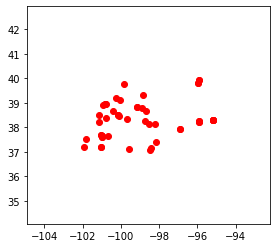

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black')

minx, miny, maxx, maxy = geo_wdf.total_bounds
ax.set_xlim(minx-3, maxx+3)
ax.set_ylim(miny-3, maxy+3)

cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))
cities.plot(ax=ax, color='b')


# We can now plot our ``GeoDataFrame``.
geo_wdf.plot(ax=ax, color='red')

plt.show()

Bardziej złożona mapa generowana za pomocą folium

In [ ]:
#określamy średnią długość i szerokość do wycentrowania mapy
mean_Lat = np.median(geo_wdf.Latitude)
mean_Long = np.median(geo_wdf.Longitude)

#tworzymy obiekt mapy
folium_map = folium.Map(
                location = [mean_Lat, mean_Long], 
                zoom_start = 8,width=1300,height=650)


In [ ]:
#tworzymy i dodajemy geometrię punktów do mapy (ze zwykłej ramki pandas)
wells_points = folium.map.FeatureGroup()
latitudes = list(wdf.Latitude)
longitudes = list(wdf.Longitude)
leases = list(wdf.Lease)
gammas = list(wdf.gamma)

for lat, lng, lsl, g in zip(latitudes, longitudes, leases, gammas):
  popup_text = lsl + "\n" + str(g) + " gamma API at " + str(interpolation_depth)+" ft."
  folium.Marker(location = [lat, lng],icon = folium.Icon(color='blue', icon='star'),popup = popup_text).add_to(folium_map)
folium_map

In [ ]:
#tu tylko test jak działa np.interp (interpolacja liniowa)
np.interp(x=5,xp=[2,3,6,7,8],fp =[4,9,36,49,64])

27.0

Zapis georamki do pliku shp

In [ ]:
geo_wdf.describe()

,gamma,KGS_ID,Latitude,Longitude,Elevation,Depth_start,Depth_stop
count,75.000000,7.700000e+01,77.000000,77.000000,77.000000,77.000000,77.000000
mean,85.323363,1.047328e+09,38.642631,-99.452515,2345.857143,230.532468,4199.636364
std,89.952923,1.527032e+06,0.673318,1.688105,698.375384,349.483852,742.803277
min,8.985100,1.046232e+09,37.005786,-101.525519,1260.000000,-8.000000,2307.000000
25%,56.261250,1.046798e+09,38.417436,-100.872582,1831.000000,0.000000,3505.000000
50%,77.325000,1.046807e+09,38.721937,-99.836293,2342.000000,195.000000,4450.000000
75%,95.972450,1.046822e+09,39.031556,-98.709827,3024.000000,245.000000,4851.000000
max,791.924300,1.051684e+09,39.972378,-96.131540,3431.000000,1800.000000,5606.000000


## Interpolacja IDW

z wykorzystaniem pakietu gdal

dane będą z georamki geo_wdf

In [ ]:
#określanie zasięgu mapy - będzie potrzebne do interpolacji w gdal
map_bounds = [geo_wdf.bounds.minx.min(),geo_wdf.bounds.miny.min(),geo_wdf.bounds.maxx.max(),geo_wdf.bounds.maxy.max()]
map_bounds

[-101.9073103, 37.0584128, -95.9362942, 39.943543]

In [ ]:
geo_wdf.to_file('tmp.shp') #tymczasowy plik shp potrzebny bo gdal nie czyta georamki

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


Do interpolacji służy funkcja **gdal.Grid**, tworząca z nieregularnie rozrzuconych punktów regularną siatkę (raster)

Punkty podajemy jako shapefile, wynik będzie zapisany jako plik r.tif. Zmienną do interpolacji podajemy jako argument zfield.

(za przykładem [stąd](https://gis.stackexchange.com/questions/313191/how-to-use-gdalgridinversedistancetoapower-in-a-python-script) )

In [ ]:
r= gdal.Grid('r.tif','tmp.shp',format = 'GTiff', width = int(x_span*200), height=int(y_span*200),
               algorithm='invdist:power=2.0:smoothing=2.0',
               zfield='gamma',
               outputType=gdal.GDT_Float32,
               outputBounds = map_bounds)

In [ ]:
r = None #dopiero po tym plik zapisuje się na dysku

#plik r.tif  to geotiff, który otwiera się w QGIS! i w ArcGIS też po dodaniu output_type

In [ ]:
os.path.getsize("r.tif") #test czy wynikowy plik się zapisał był

5516536

Teraz można pobrać plik r.tif; powinien się prawidłowo wczytywać do ArcGIS/QGIS. Dodatkowo pliki tmp.* zawierają shapefile z analizowanymi otworami.

In [ ]:
%pip install rasterio
import rasterio
from rasterio import mask

     |████████████████████████████████| 19.3 MB 1.1 MB/s 


[https://omdena.com/blog/geospatial-data-analytics](https://omdena.com/blog/geospatial-data-analytics/)

## Dodatkowo - kriging

**działa ale słabo**

Kriging z wykorzystaniem pakietu pykrige. Niby działa, ale trzeba opanować eksport wynikowej macierzy np. do geotiff'a.

[stąd](https://www.tomasbeuzen.com/python-for-geospatial-analysis/chapters/chapter2_spatial-viz-and-modelling.html)

In [ ]:
#tworzymy siatkę, georamka ma sprytne metody .bounds.minx.min itd do okreśalnia zasięgu danych
resolution = .01 #w stopniach póki co
gridx = np.arange(geo_wdf.bounds.minx.min(), geo_wdf.bounds.maxx.max(), resolution)
gridy = np.arange(geo_wdf.bounds.miny.min(), geo_wdf.bounds.maxy.max(), resolution)



In [ ]:
x_span = (geo_wdf.bounds.maxx.max() - geo_wdf.bounds.minx.min())
y_span = (geo_wdf.bounds.maxy.max() - geo_wdf.bounds.miny.min())
print (x_span)
print (y_span)

5.9710161
2.885130199999999


In [ ]:
vario = Variogram(coordinates=geo_wdf[["Longitude","Latitude"]],
                  values=geo_wdf["gamma"],
                  n_lags=20)

{'dist_func': 'euclidean',
 'effective_range': 6.572488459871654,
 'estimator': 'matheron',
 'kwargs': {},
 'model': 'spherical',
 'normalized_effective_range': 43.19760455514608,
 'normalized_nugget': 0,
 'normalized_sill': 8193772.892241895,
 'nugget': 0,
 'params': {'bin_func': 'even',
  'dist_func': 'euclidean',
  'estimator': 'matheron',
  'fit_method': 'trf',
  'fit_sigma': None,
  'maxlag': None,
  'model': 'spherical',
  'n_lags': 20,
  'normalize': False,
  'use_nugget': False,
  'verbose': False},
 'sill': 2171.2272781230745}

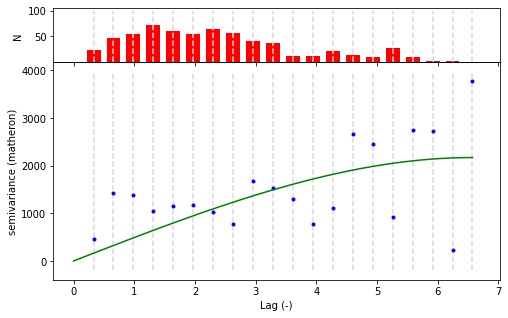

In [ ]:
vario.plot(hist=True)
vario.describe()


In [ ]:
vario.fitted

<bound method Variogram.fitted_model_function of <class 'skgstat.Variogram.Variogram'>>

Plotting Enabled

Initializing variogram model...
Coordinates type: 'geographic' 

Using 'linear' Variogram Model
Slope: 195.6461633975384
Nugget: 785.5656305290033 



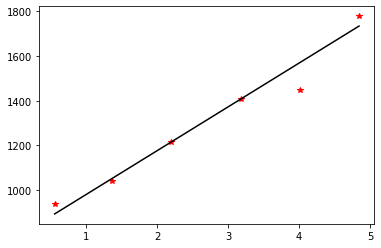

Calculating statistics on variogram model fit...


In [ ]:
OK = pkg.OrdinaryKriging(
    x=geo_wdf["x"],
    y=geo_wdf["y"],
    z=geo_wdf["gamma"],
    variogram_model="linear",
    verbose=True,
    enable_plotting=True,
    coordinates_type='geographic'
)

Executing Ordinary Kriging...



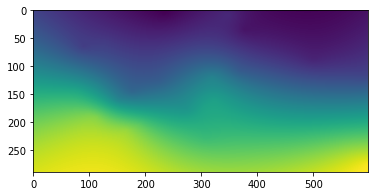

In [ ]:
z, ss = OK.execute("grid",gridx, gridy)
plt.imshow(z)
plt.show()